# Task 3: Analysis and Visualization

Load data

In [7]:
import sqlite3
import pandas as pd

con = sqlite3.connect('../parts_avatar.db')

product_metadata_df = pd.read_sql_query('SELECT * FROM product_metadata', con)
supplier_data_df = pd.read_sql_query('SELECT * FROM supplier_data', con)

print(f'Product metadata df:\n{product_metadata_df.head(5)}')
print(f'\nSupplier data df:\n{supplier_data_df.head(5)}')

Product metadata df:
  part_id        part_name     category
0  SP-101  Electronic Pump  Electronics
1  SP-102    Engine Sensor       Engine
2  SP-103   Engine Pad Set       Engine
3  SP-104     Filter Rotor      Filters
4  SP-105      Brake Rotor       Brakes

Supplier data df:
   id part_id  stock_level  cost_price           entry_date
0   1  SP-236           30      287.32  2024-06-29 00:00:00
1   2  SP-325          248      388.87  2025-03-17 00:00:00
2   3  SP-179           82      109.00  2025-04-14 00:00:00
3   4  SP-332          171      419.60  2025-05-10 00:00:00
4   5  SP-268           72      279.69  2024-04-08 00:00:00


## What is the average cost price per product category?

We must join the datasets on `part_id` (excluding parts  that don't have a match, i.e. inner join), group by `category`, and compute the averages of `cost_price`

Joined dataset:
   id part_id  stock_level  cost_price           entry_date      part_name  \
0   1  SP-236           30      287.32  2024-06-29 00:00:00    HVAC Sensor   
1   2  SP-325          248      388.87  2025-03-17 00:00:00  Filter Sensor   
2   3  SP-179           82      109.00  2025-04-14 00:00:00    Filter Pump   
3   4  SP-332          171      419.60  2025-05-10 00:00:00    HVAC Gasket   
4   5  SP-268           72      279.69  2024-04-08 00:00:00     Brake Pump   

  category  
0     HVAC  
1  Filters  
2  Filters  
3     HVAC  
4   Brakes  

Average cost price per category:
category
Brakes         230.01
Electronics    226.86
Engine         228.92
Exhaust        224.42
Filters        229.78
HVAC           226.80
Suspension     233.00
Name: cost_price, dtype: float64


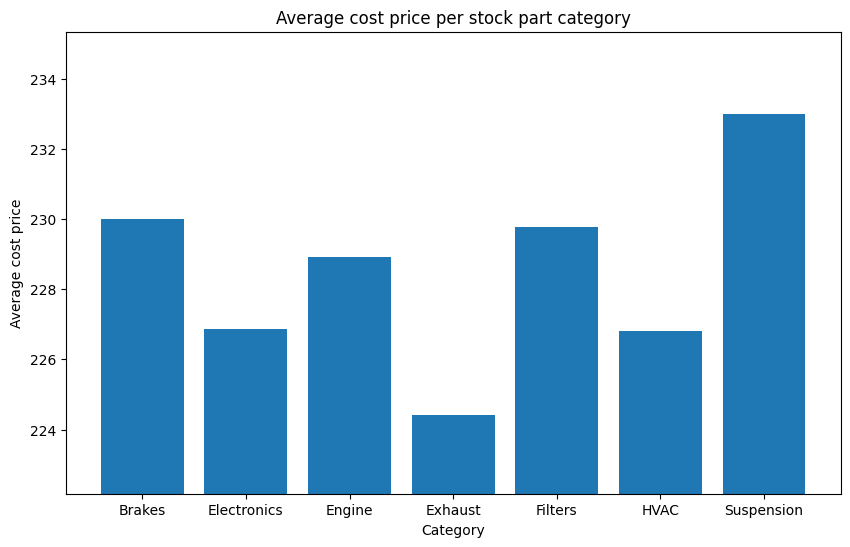

In [32]:
# inner join datasets on part_id
join_on_part_id = pd.merge(left=supplier_data_df, 
                           right=product_metadata_df, 
                           left_on='part_id', 
                           right_on='part_id', 
                           how='inner')

print(f'Joined dataset:\n{join_on_part_id.head(5)}')

# group by category and get mean cost_price
cost_price_per_category = join_on_part_id.groupby('category')['cost_price']
avg_cost_price_per_category = cost_price_per_category.mean()

print(f'\nAverage cost price per category:\n{avg_cost_price_per_category.round(2)}')

# make a bar plot of the average cost prices per category
import matplotlib.pyplot as plt
 
plt.figure(figsize=(10, 6))
plt.bar(avg_cost_price_per_category.index, avg_cost_price_per_category.values)
plt.ylim(avg_cost_price_per_category.min() * 0.99, avg_cost_price_per_category.max() * 1.01)
plt.xlabel('Category')
plt.ylabel('Average cost price')
plt.title('Average cost price per stock part category')
plt.show()

## Which top 5 parts have the highest stock levels right now?

We must find the latest stock count for each part (group by `part_id`), and get the 5 with the highest stock level. This is equivalent to finding the "largest" entry date per part.

Top 5 parts with highest stock levels right now:
      part_id  stock_level           entry_date
6915   SP-471          493  2025-07-21 00:00:00
15986  SP-200          492  2025-07-19 00:00:00
9939   SP-345          492  2025-07-27 00:00:00
28630  SP-305          490  2025-07-26 00:00:00
24531  SP-440          489  2025-07-31 00:00:00


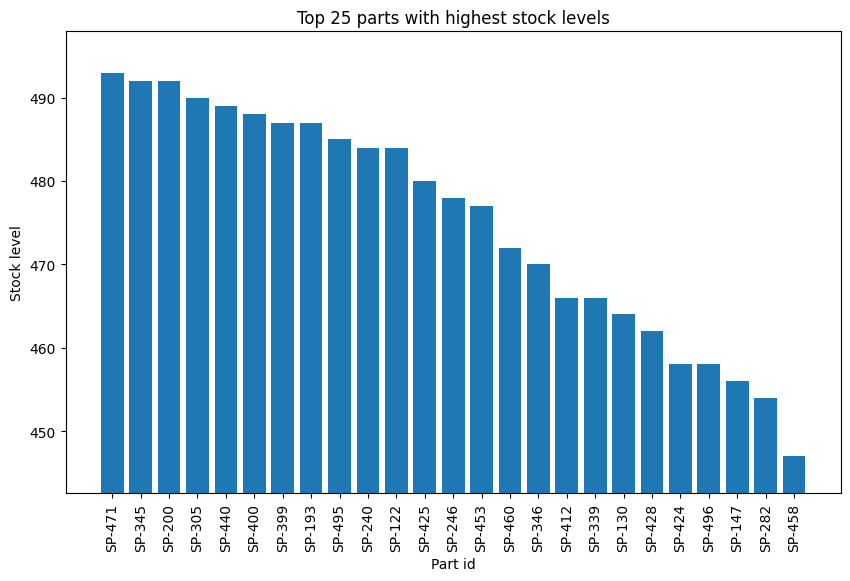

In [59]:
idx_of_latest_per_part = supplier_data_df.groupby('part_id')['entry_date'].idxmax() # return index of row with largest entry date per part
latest_stock_per_part = supplier_data_df.loc[idx_of_latest_per_part]                # get respective stock data

# get top 5 parts
top_5_parts = latest_stock_per_part.nlargest(n=5, columns='stock_level').sort_values(by='stock_level', ascending=False)
print(f'Top 5 parts with highest stock levels right now:\n{top_5_parts[['part_id', 'stock_level', 'entry_date']]}')

# for visualization, sort all latest stock counts per part, descending
top_25_parts = latest_stock_per_part.sort_values(by='stock_level', ascending=False).head(25)

plt.figure(figsize=(10, 6))
plt.bar(top_25_parts['part_id'], top_25_parts['stock_level'])
plt.ylim(top_25_parts['stock_level'].min() * 0.99, top_25_parts['stock_level'].max() * 1.01)
plt.title('Top 25 parts with highest stock levels')
plt.xlabel('Part id')
plt.ylabel('Stock level')
plt.xticks(rotation=90)
plt.show()

## How has the number of new parts entries from this supplier changed over time (on a monthly basis)?

We want to find the difference of the number of parts present per month. So we must group by similar year-months, and compare each one with the year-month before (shift).

Entry dates extracted as year-month:
0    2024-06
1    2025-03
2    2025-04
3    2025-05
4    2024-04
Name: entry_date_year_month, dtype: period[M]

Number of entries per year-month:
entry_date_year_month
2024-01    1593
2024-02    1478
2024-03    1607
2024-04    1546
2024-05    1594
Freq: M, dtype: int64

Number of entries for previous year-month:
entry_date_year_month
2024-01       NaN
2024-02    1593.0
2024-03    1478.0
2024-04    1607.0
2024-05    1546.0
Freq: M, dtype: float64


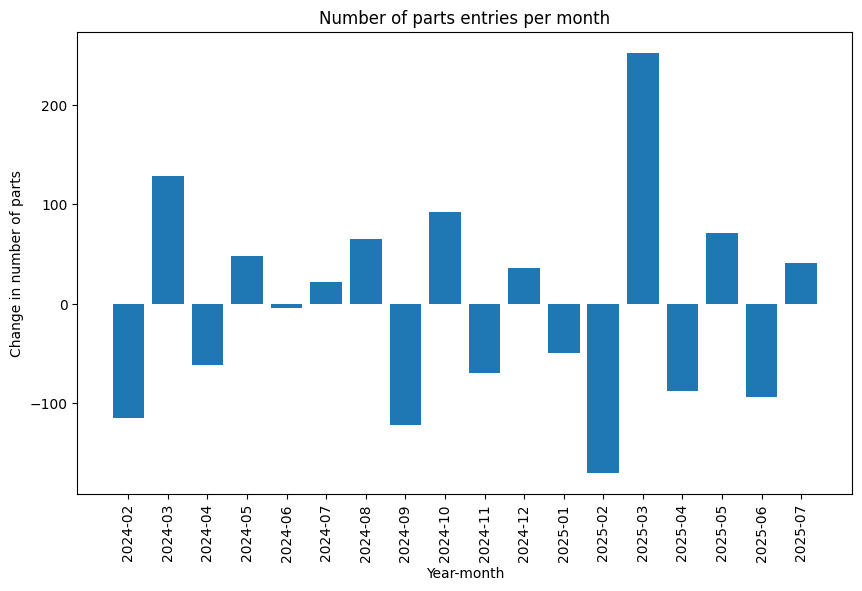

In [88]:
# convert entry dates to year-month
supplier_data_df['entry_date'] = pd.to_datetime(supplier_data_df['entry_date'], errors='coerce')
supplier_data_df['entry_date_year_month'] = supplier_data_df['entry_date'].dt.to_period('M')

print(f'Entry dates extracted as year-month:\n{supplier_data_df['entry_date_year_month'].head(5)}')

# group by year-month and get number of rows per group
parts_per_month = supplier_data_df.groupby('entry_date_year_month').size()
print(f'\nNumber of entries per year-month:\n{parts_per_month.head(5)}')

# shift to get entries of previous month at same row
previous_parts_per_month = parts_per_month.shift(1)
print(f'\nNumber of entries for previous year-month:\n{previous_parts_per_month.head(5)}')

# get differences between months
parts_differences = parts_per_month.values - previous_parts_per_month.values

# bar plot
plt.figure(figsize=(10, 6))
plt.bar(parts_per_month.index[1:].astype(str), parts_differences[1:])
# plt.ylim(top_25_parts['stock_level'].min() * 0.99, top_25_parts['stock_level'].max() * 1.01)
plt.title('Number of parts entries per month')
plt.xlabel('Year-month')
plt.ylabel('Change in number of parts')
plt.xticks(rotation=90)
plt.show()